In [1]:
import numpy as np
import pandas as pd
import warnings
import time
import datetime
import re
import random

from sklearn.metrics import precision_recall_fscore_support

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# PyTorch Imports
import torch # a tensor library
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Huggingface Transformers
import transformers
from transformers import get_linear_schedule_with_warmup

from transformers import LongformerModel, LongformerTokenizer
from transformers import LongformerForSequenceClassification, AdamW, BertConfig

## Model Set Up
Set up the model and the configuration we need

- max_len - how many tokens will be used from the document.
- batch_size - reduce if memory issues. paper reccomends 16-32
- num epochs

- tokenizer - this should be a pretrined tokenizer, e.g. distilBert. 
- model - make sure it uses the same tokenizer for generating the weights

#### input files
- train.csv: heading removed, dates and URL replcaed, un-cased, sentence breaks and punctuation included  
- train_lcase.csv: heading removed, dates and URL replcaed, lower cased, sentence breaks and punctuation removed
  

In [2]:
train_file = "data/train.csv"
test_file = "data/test.csv"

max_len = 512
batch_size = 8
num_epochs = 3

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                       num_labels = 2,
                                                       output_attentions = False,
                                                       output_hidden_states = False)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

## Helper Functions

In [3]:
# Function to get data
def get_data(fname):
    df = pd.read_csv(fname)
    df = df[['cleaned_contents', 'Discrimination_Label']]
    df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
    df.reset_index(inplace=True, drop=True)
    return df

In [4]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [5]:
# Function to format elapsed time 
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
# Function to tokenize data and return tensors for input ids, attention mask and labels
def tokenize_plus(df):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    sentences = df['text'].values
    labels = df['label'].values

    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
# Add 

# Fine Tuning and training

In [7]:
df = get_data(train_file)
#df = df.sample(n = 10) # limit size for testing 
df.head()

,text,label
0,SENTENCE\n\n\t1.\tYou are charged as follows:\...,0
1,"SENTENCE\n\n\t1.\tJOSEFA KOTOBALAVU, you were ...",1
2,SENTENCE\n\n1. The Director of Public Prosecut...,1
3,"SENTENCE\n\n\t1.\tMOHOMMED NABI UD- DEAN, you ...",1
4,JUDGMENT OF THE COURT\n\nBackground\n\n[1] The...,0


In [8]:
# Tokenize test data using tokenizer.encode_plus, put into a pytorch dataloader
input_ids, attention_masks, labels = tokenize_plus(df)

In [9]:
# check size of embeddings
print(len(input_ids))
print(len(input_ids[0]))

# Use torchsummary to print out layers nicely, needs the imput shape
#p!ip install torchsummary
#summary(your_model, input_size=(channels, H, W))
#from torchsummary import summary
#summary(model, input_size=(8, 647, 512))


647
512


In [10]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

In [11]:
# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  582 training samples
   65 validation samples


In [12]:
# Create the DataLoaders for our training and validation sets.
# Take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [13]:
# Tell pytorch to run this model on the GPU.
model.cuda()

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_

In [14]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [15]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = num_epochs

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [16]:
# Train the model
device = torch.device("cuda")

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of     73.    Elapsed: 0:01:04.

  Average training loss: 0.67
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.57
  Validation took: 0:00:04

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     73.    Elapsed: 0:01:06.

  Average training loss: 0.65
  Training epcoh took: 0:02:01

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.55
  Validation took: 0:00:04

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     73.    Elapsed: 0:01:07.

  Average training loss: 0.62
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.53
  Validation took: 0:00:04

Training complete!
Total training took 0:06:13 (h:mm:ss)


In [17]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.67,0.57,0.76,0:01:58,0:00:04
2,0.65,0.55,0.76,0:02:01,0:00:04
3,0.62,0.53,0.79,0:02:03,0:00:04


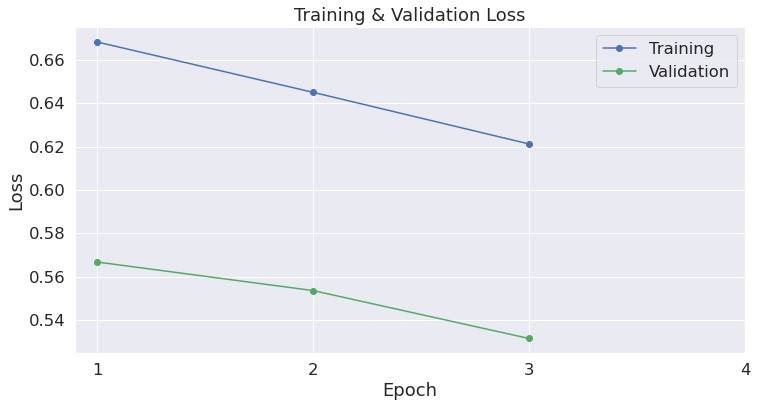

In [18]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# TEST THE MODEL

In [19]:
# Holdoit
df = get_data(test_file)
df.head()

,text,label
0,SENTENCE\n\n[Name of the victim is suppressed....,1
1,JUDGMENT\n\nThis is an appeal against convicti...,1
2,"JUDGMENT\n\n1. On 13 May 2008, the Appellant, ...",1
3,JUDGMENT\n[1] On the 17th July 2012 in the Nas...,0
4,SENTENCE\n\nBackground \n\n1. The accused was ...,1


In [20]:
# Tokenize test data using tokenizer.encode_plus, put into a pytorch dataloader
input_ids, attention_masks, labels = tokenize_plus(df)

In [21]:
# create dataloader from input tensors, to help with memory usage
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [22]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 162 test sentences...
    DONE.


In [23]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 97 of 162 (59.88%)


In [24]:

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

scores = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='binary')

# Calculate the P,R,F1
print('Precision, Recall, F1, Support:', scores)

Precision, Recall, F1, Support: (0.7090909090909091, 0.8041237113402062, 0.753623188405797, None)


In [25]:
# get the bad predictions index
bad_preds = [idx for idx, elem in enumerate(flat_predictions) if elem != flat_true_labels[idx]] 
good_preds = [idx for idx, elem in enumerate(flat_predictions) if elem == flat_true_labels[idx]] 
print("number of good predictions:", len(good_preds))
print("number of bad predictions:", len(bad_preds))
print("accuracy", len(good_preds)/len(flat_predictions) )

number of good predictions: 111
number of bad predictions: 51
accuracy 0.6851851851851852


In [26]:
print(flat_predictions)

[1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0
 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1
 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0
 0 0 1 0 0 1 1 1 1 1 1 1 1 1]


In [41]:
df_good=df.iloc[good_preds]
df_bad = df.iloc[bad_preds]

pandas.core.frame.DataFrame